# import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torch.distributed import get_rank, init_process_group, destroy_process_group, all_gather, get_world_size

import argparse
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import wandb

from models.embedding import *
from models.mlp import *
from models.ddpm_scheduler import NoiseScheduler
from utils.optimization import get_scheduler
from models.ddpm import *
from datasets import PointDataset

ModuleNotFoundError: No module named 'utils.optimization'; 'utils' is not a package

# Load model weight

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_scheduler = NoiseScheduler(num_timesteps=50)

time_embedding = SinusoidalEmbedding(size=10)

nn_model = MLP(
    hidden_layers=3,
    input_size=2,
    emb_size=10,
    hidden_size=128
).to(device)

obj_embedding = LabelEmbedding(
    num_classes=5,
    hidden_size=10,
    dropout_prob=0.1
).to(device)
atr_embedding = LabelEmbedding(
    num_classes=5,
    hidden_size=10,
    dropout_prob=0.1
).to(device)

state_dict = torch.load('checkpoints/DDPM_Missing_A3B3/model_200.pth')
obj_embedding.load_state_dict(state_dict['obj_embedding'])
atr_embedding.load_state_dict(state_dict['atr_embedding'])
nn_model.load_state_dict(state_dict['noise_predictor'])

<All keys matched successfully>

In [15]:
x_i = torch.randn(1000, 2).to(device)
c1 = torch.tensor(2)
c2 = torch.tensor(2)
c1 = c1.repeat(1000)
c2 = c2.repeat(1000)
c1, c2 = c1.to(device), c2.to(device)
c1_con = obj_embedding(c1, evaluation=True)
c2_con = atr_embedding(c2, evaluation=True)
c1_unc = obj_embedding(c1, force_drop_ids=True)
c2_unc = atr_embedding(c2, force_drop_ids=True)

timesteps = list(range(50))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    ts = torch.tensor([t]).repeat(1000)
    temb = time_embedding(ts).to(device)
    with torch.no_grad():
        cond_pred = nn_model(x_i, c1_con, c2_con, temb)
        uncond_pred = nn_model(x_i, c1_unc, c2_unc, temb)
        
        eps = (1 + 1.8) * cond_pred - 1.8 * uncond_pred
    x_i = noise_scheduler.step(eps.cpu(), t, x_i.cpu())
    if i % 5 == 0:
        tmp = x_i.numpy()
        tmp = tmp * 2.5 + 2.5
        plt.plot(tmp[:, 0], tmp[:, 1], marker='.', linestyle="")
        plt.title(f'timestep {i}')
        plt.xlim([0, 6])
        plt.ylim([0, 6])
        plt.savefig(os.path.join('result', 'DDPM_Missing_A3B3', f'A3 B3 timestep {i}.png'))
        plt.clf()
    x_i = x_i.to(device)

100%|██████████| 50/50 [00:01<00:00, 32.13it/s]


<Figure size 640x480 with 0 Axes>

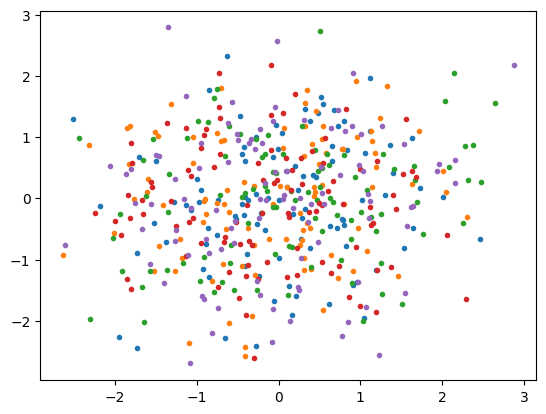

In [11]:
for i in range(5):
    x, y = np.random.randn(100), np.random.randn(100)
    plt.plot(x, y, marker='.', linestyle="")

# Calculate average accuracy based on csv file

In [23]:
import pandas as pd

df = pd.read_csv("result/model_20.csv")

print(df["Top1"].mean(), df["Top5"].mean())

22.555556037773687 68.91296392789593


In [9]:
df = pd.read_csv("result/model_20.csv")
print(df["Top1"].mean(), df["Top5"].mean())

22.555556037773687 68.91296392789593


In [11]:
df = pd.read_csv("result/model_15.csv")
print(df["Top1"].mean(), df["Top5"].mean())

16.63333354007315 63.075926736273146


In [24]:
df = pd.read_csv("result/NoMissV2.csv")
print(df["Top1"].mean(), df["Top5"].mean())

15.851852122832227 86.96296424667041


In [50]:
from config import TripleCond

CFG = TripleCond()

df = pd.read_csv("result/NoMissV2.csv")

top1 = []
top5 = []

for s in CFG.IDX2SIZE.values():
    for i, row in df.iterrows():
        if s in row["Label"]:
            top1.append(row["Top1"])
            top5.append(row["Top5"])

    print(f"{s} Average")
    print(sum(top1) / len(top1), sum(top5) / len(top5))
    top1.clear()
    top5.clear()

for a in CFG.IDX2ATR.values():
    for i, row in df.iterrows():
        if a in row["Label"]:
            top1.append(row["Top1"])
            top5.append(row["Top5"])

    print(f"{a} Average")
    print(sum(top1) / len(top1), sum(top5) / len(top5))
    top1.clear()
    top5.clear()

for o in CFG.IDX2OBJ.values():
    for i, row in df.iterrows():
        if o in row["Label"]:
            top1.append(row["Top1"])
            top5.append(row["Top5"])

    print(f"{o} Average")
    print(sum(top1) / len(top1), sum(top5) / len(top5))
    top1.clear()
    top5.clear()

small Average
39.35000069936117 90.48888958825006
medium Average
1.0166666739516788 80.28333487444453
big Average
7.188888995183839 90.11666827731662
red Average
15.80000048213535 89.64444510142009
green Average
15.755555709203085 87.48889032999675
blue Average
16.577777942021687 86.04444558752908
yellow Average
16.877777983744938 84.97777880562677
black Average
16.566666973961723 87.31111293368869
purple Average
13.533333645926582 86.31111272176106
Circle Average
5.388888958427641 70.4444455769327
Rectangle Average
30.711111704508465 98.92222256130643
Triangle Average
37.122222900390625 94.30000135633681
Pentagon Average
4.155555619133843 94.82222408718533
Oval Average
14.933333496252695 90.9444457160102
Hexagon Average
2.800000058280097 72.34444618225098


In [57]:
import torch.nn.functional as F
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [62]:
image_feature = torch.tensor([[.1, .2, .2, .2], [.5, .4, .2, .4]])
class_feature = torch.tensor([[.1, .2, .2, .2], [.3, .1, .2, .4]])

image_s = image_feature @ image_feature.T
class_s = class_feature @ class_feature.T

logit = class_feature @ image_feature.T

targets = F.softmax(
    (image_s + class_s) / 2, dim=-1
)
targetV2 = torch.arange(2)
print(logit, logit.T, sep="\n")

tensor([[0.1300, 0.2500],
        [0.1700, 0.3900]])
tensor([[0.1300, 0.1700],
        [0.2500, 0.3900]])


In [60]:
criterion = torch.nn.CrossEntropyLoss()

loss = criterion(logit.T, targetV2)

print(loss, cross_entropy(logit, targets).mean())

tensor(0.6695) tensor(0.6892)


In [ ]:
from models.ccip import CMLIPModel
from collections import OrderedDict

device = torch.device("cuda")
model = CMLIPModel(
    num_size=3,
    num_atr=6,
    num_obj=6,
    projection_dim=512,
)

ckpt = torch.load("checkpoints/CCIP_TripleCond/NoMissV2/model_30.pth")["model"]
    
new_dict = OrderedDict()

for k, v in ckpt.items():
    if k.startswith("module"):
        new_dict[k[7:]] = v
    else:
        new_dict[k] = v
try:
    model.load_state_dict(new_dict)
    print("All keys successfully match")
except:
    print("some keys are missing!")

for p in model.parameters():
    p.requires_grad = False

model.to(device)

In [32]:
num_size = 3
num_atr = 6
num_obj = 6

c1 = torch.cat([torch.full((num_atr * num_obj,), i) for i in range(num_size)], dim=-1)
c2 = torch.arange(0, num_atr)
c3 = torch.arange(0, num_obj)
c2 = c2.repeat(num_obj, 1).permute(1, 0).reshape(-1)
c3 = c3.repeat(num_atr)
c2 = c2.repeat(num_size)
c3 = c3.repeat(num_size)
c1, c2, c3 = c1.to(device), c2.to(device), c3.to(device)

class_feature = model.encode_class(c1, c2, c3)
class_feature = F.normalize(class_feature, p=2, dim=-1)

In [34]:
from PIL import Image

image = Image.open("/root/notebooks/nfs/work/dataset/toy_dataset_366_500/medium red Circle/00000.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

image = transform(image)[None, :, :, :].to(device)

image_feature = model.encode_image(image)
image_feature = F.normalize(image_feature, p=2, dim=-1)

In [47]:
# image_similarity = image_feature @ image_feature.T
dot_similarity = image_feature @ class_feature.T
dot_similarity

tensor([[0.3740, 0.4210, 0.3377, 0.3629, 0.4301, 0.3677, 0.2528, 0.2857, 0.2048,
         0.2349, 0.2904, 0.2356, 0.2739, 0.3120, 0.2380, 0.2617, 0.3142, 0.2602,
         0.2547, 0.2883, 0.2137, 0.2322, 0.2903, 0.2377, 0.2608, 0.3049, 0.2240,
         0.2459, 0.3025, 0.2488, 0.3456, 0.3851, 0.2956, 0.3308, 0.3923, 0.3311,
         0.3436, 0.3715, 0.3206, 0.3183, 0.3540, 0.3283, 0.2145, 0.2340, 0.1745,
         0.1876, 0.2208, 0.1917, 0.2394, 0.2641, 0.2112, 0.2180, 0.2487, 0.2199,
         0.2180, 0.2391, 0.1858, 0.1877, 0.2254, 0.1959, 0.2269, 0.2563, 0.1975,
         0.2028, 0.2373, 0.2090, 0.3117, 0.3340, 0.2757, 0.2850, 0.3160, 0.2898,
         0.3841, 0.3827, 0.3328, 0.3395, 0.3432, 0.3419, 0.2479, 0.2478, 0.1880,
         0.2068, 0.2193, 0.2064, 0.2784, 0.2822, 0.2305, 0.2415, 0.2493, 0.2381,
         0.2563, 0.2562, 0.2025, 0.2099, 0.2271, 0.2137, 0.2597, 0.2704, 0.2125,
         0.2226, 0.2357, 0.2235, 0.3519, 0.3451, 0.2871, 0.3052, 0.3069, 0.3034]],
       device='cuda:0')

In [39]:
_, indice = torch.topk(dot_similarity, 5)
indice

tensor([[ 4,  1, 34, 31, 72]], device='cuda:0')

In [42]:
from config import TripleCond

CFG = TripleCond()
print(CFG.classes[4], CFG.classes[1], CFG.classes[34], CFG.classes[31], CFG.classes[72])

small red Oval small red Rectangle small purple Oval small purple Rectangle big red Circle


In [43]:
CFG.CLS2IDX

{'small red Circle': 0,
 'small red Rectangle': 1,
 'small red Triangle': 2,
 'small red Pentagon': 3,
 'small red Oval': 4,
 'small red Hexagon': 5,
 'small green Circle': 6,
 'small green Rectangle': 7,
 'small green Triangle': 8,
 'small green Pentagon': 9,
 'small green Oval': 10,
 'small green Hexagon': 11,
 'small blue Circle': 12,
 'small blue Rectangle': 13,
 'small blue Triangle': 14,
 'small blue Pentagon': 15,
 'small blue Oval': 16,
 'small blue Hexagon': 17,
 'small yellow Circle': 18,
 'small yellow Rectangle': 19,
 'small yellow Triangle': 20,
 'small yellow Pentagon': 21,
 'small yellow Oval': 22,
 'small yellow Hexagon': 23,
 'small black Circle': 24,
 'small black Rectangle': 25,
 'small black Triangle': 26,
 'small black Pentagon': 27,
 'small black Oval': 28,
 'small black Hexagon': 29,
 'small purple Circle': 30,
 'small purple Rectangle': 31,
 'small purple Triangle': 32,
 'small purple Pentagon': 33,
 'small purple Oval': 34,
 'small purple Hexagon': 35,
 'medium